<a href="https://colab.research.google.com/github/acastellanos-ie/NLP-MBDS-EN/blob/main/03_linguistic_structure_and_interpretability/attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 3: The Anatomy of Attention (Lab)

**Learning Objective:**
Dismantle the premise that LLMs "understand" text. We will empirically demonstrate that contextual understanding is, at a physical level, a **weighted information routing** mechanism (Attention).

We will run a Winograd Schema experiment to see how matrix weights dynamically change based on context.

In [1]:
# 1. Base dependencies installation
!pip install -q transformers bertviz matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.3 MB/s eta 0:00:00


### Phase 1: Loading the Model in "Autopsy" Mode
By default, models discard attention weights after prediction to save memory. We will force the model to return these tensors (`output_attentions=True`).

In [2]:
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns


model_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id, output_attentions=True)

print(f"Loaded model: {model_id} | Parameters: {sum(p.numel() for p in model.parameters()):,}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loaded model: bert-base-uncased | Parameters: 109,482,240


### Phase 2: The Winograd Experiment
We will evaluate how the model resolves the ambiguity of the pronoun "it" based on a single adjective at the end of the sentence.

In [3]:
# Sentence A: 'it' refers to the animal (because it was tired)
text_a = "The animal didn't cross the street because it was too tired."

# Sentence B: 'it' refers to the street (because it was wide)
text_b = "The animal didn't cross the street because it was too wide."

# Tokenization
inputs_a = tokenizer(text_a, return_tensors='pt')
inputs_b = tokenizer(text_b, return_tensors='pt')

tokens_a = tokenizer.convert_ids_to_tokens(inputs_a['input_ids'][0])
tokens_b = tokenizer.convert_ids_to_tokens(inputs_b['input_ids'][0])

# Inference (Forward pass)
with torch.no_grad():
    outputs_a = model(**inputs_a)
    outputs_b = model(**inputs_b)

# Extracting the attention tuple
# Format: (num_layers) x Tensor[batch_size, num_heads, seq_len, seq_len]
attentions_a = outputs_a.attentions
attentions_b = outputs_b.attentions

print(f"Tokens Sentence A: {tokens_a}")

Tokens Sentence A: ['[CLS]', 'the', 'animal', 'didn', "'", 't', 'cross', 'the', 'street', 'because', 'it', 'was', 'too', 'tired', '.', '[SEP]']


### Phase 3: Visual Abstraction (BertViz)
We render the connection between tokens.
**Instructions for the student:**
1. Select Layer 9.
2. Hover over the word "it" in the left column.
3. Observe the thickness of the lines towards the right column.

In [4]:
from bertviz import head_view

# Visualizing Sentence A
# Note for Colab: If it doesn't render, run this cell again.
head_view(attentions_a, tokens_a)

<IPython.core.display.Javascript object>

In [6]:
head_view(attentions_b, tokens_b)

<IPython.core.display.Javascript object>

### Phase 4: The Signal in the Noise (Delta Matrix)
Raw attention matrices are dominated by "sink" tokens (like `[SEP]` or `.`) which absorb 60-80% of the attention mass, squashing the color scale. To see the true routing shift, we must calculate the **Delta (Matrix A - Matrix B)**. This cancels out the structural noise and isolates the semantic signal.

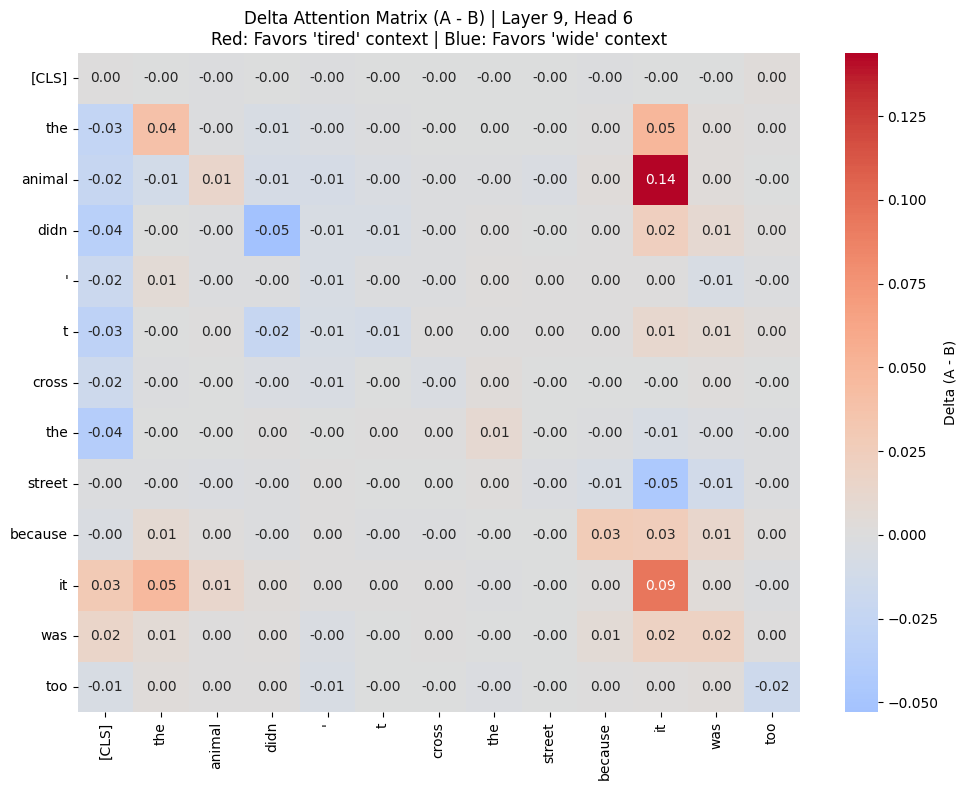


--- Raw Attention Weights from 'it' ---
Context A ('tired'): 'it' -> 'animal' = 0.0148 | 'it' -> 'street' = 0.0005
Context B ('wide') : 'it' -> 'animal' = 0.0010 | 'it' -> 'street' = 0.0008

Conclusion: The absolute shift is mathematically small, but the relative shift proves the routing logic changed.


In [5]:
import numpy as np

# We analyze a deep layer typically associated with semantics/coreference
target_layer = 9
target_head = 6

matrix_a = attentions_a[target_layer][0, target_head].numpy()
matrix_b = attentions_b[target_layer][0, target_head].numpy()

# Calculate the difference to isolate the signal
# We trim the matrices to the minimum shared length (ignoring the last word which differs in length)
min_len = min(matrix_a.shape[0], matrix_b.shape[0]) - 3
delta_matrix = matrix_a[:min_len, :min_len] - matrix_b[:min_len, :min_len]
shared_tokens = tokens_a[:min_len]

# Visualizing the DELTA
plt.figure(figsize=(10, 8))
# We use a diverging colormap (coolwarm).
# Red means A > B (attention shifted to 'animal').
# Blue means B > A (attention shifted to 'street').
sns.heatmap(delta_matrix, xticklabels=shared_tokens, yticklabels=shared_tokens,
            cmap="coolwarm", center=0, annot=True, fmt=".2f", cbar_kws={'label': 'Delta (A - B)'})
plt.title("Delta Attention Matrix (A - B) | Layer 9, Head 6\nRed: Favors 'tired' context | Blue: Favors 'wide' context")
plt.tight_layout()
plt.show()

# --- NUMERICAL PROOF ---
it_index = shared_tokens.index('it')
animal_index = shared_tokens.index('animal')
street_index = shared_tokens.index('street')

print("\n--- Raw Attention Weights from 'it' ---")
print(f"Context A ('tired'): 'it' -> 'animal' = {matrix_a[it_index, animal_index]:.4f} | 'it' -> 'street' = {matrix_a[it_index, street_index]:.4f}")
print(f"Context B ('wide') : 'it' -> 'animal' = {matrix_b[it_index, animal_index]:.4f} | 'it' -> 'street' = {matrix_b[it_index, street_index]:.4f}")
print("\nConclusion: The absolute shift is mathematically small, but the relative shift proves the routing logic changed.")